In [1]:
import torch

from importlib import reload

import models
import plotting
import dataloaders as dl

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
import torch.nn as nn
import torch.nn.functional as F

def train_vanilla(model, device, train_loader, optimizer, epoch, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train(model, device, train_loader, optimizer, epoch, adv_loader, verbose=True):
    model.train()
    min_loss = torch.tensor(10.).log()
    #for batch_idx, (data, target) in enumerate(train_loader):
    for ((batch_idx, (data, target)), (_, (data_adv, _))) in zip(enumerate(train_loader),enumerate(adv_loader)):
        data, target = data.to(device), target.to(device)
        data_adv = data_adv.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        #input_rand = torch.rand(train_loader.batch_size,1,28,28).to(device)
        #output_rand = model(input_rand)
        output_rand = model(data_adv)

        loss = F.nll_loss(output, target) - output_rand.sum()/(10*train_loader.batch_size)
        loss.backward()
        a = torch.isnan(model.gmm.mu.grad).sum()
        b = torch.isnan(model.gmm.logvar.grad).sum()
        c = torch.isnan(model.gmm.alpha.grad).sum()

        if (a+b+c)>0:
            return loss, output, target, data_adv, data
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    av_conf = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            correct += (pred.eq(target.view_as(pred))*(c.exp()>0.5)).sum().item()
            av_conf += c.exp().sum().item()
            
    test_loss /= len(test_loader.dataset)
    av_conf /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Ave. Confidence: {:.0f}%\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), 100. * av_conf))
    return correct, av_conf
    
def test_adv(model, device, adv_test_loader):
    model.eval()
    av_conf = 0
    with torch.no_grad():
        for data, _ in adv_test_loader:
            data = data.to(device)
            output = model(data)

            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            av_conf += c.exp().sum().item()
            
    av_conf /= len(adv_test_loader.dataset)

    print('\nAve. Confidence: {:.0f}%\n'.format(100.*av_conf))
    return av_conf

In [6]:
base_model = models.NetVanilla().to(device)

In [7]:
import torch.optim as optim

lr = .001
momentum = .9

optimizer_base = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum)
for epoch in range(10):
    train_vanilla(base_model, device, train_loader, optimizer_base, epoch)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303466
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.242125
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.052248
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.267184
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.581124
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.433457
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.357042
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.260129
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.321175
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.270328
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.306382
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.370945
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.288595
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.235453
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.230057
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.176884
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.157737
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.142470
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.254140
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.134829
Train Epoch: 3 [2000

In [10]:
torch.save(base_model, 'base_model.pth')

In [8]:
base_model = torch.load('base_model.pth')
model = models.Net(base_model, X_MNIST, 1000, -764.).to(device)
torch.save(model, 'gmm_model.pth')

/home/alexm/project/notebooks/gmm-robust/models.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = (X[:,None,:]-torch.tensor(self.mu.data[None,:,:], dtype=torch.float)).norm(dim=2).min(dim=1)[1]


In [4]:
#model.log_pz_lam.data = torch.tensor(-767.132, device=device)
data = enumerate(dl.test_loader).__next__()[1][0]
y = model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y,y_base], data)

test(model, device, test_loader)
test(base_model, device, test_loader)

test_adv(model, device, EMNIST_test_loader)
test_adv(base_model, device, EMNIST_test_loader)

NameError: name 'model' is not defined

In [570]:
lr = .001
momentum = .9

optimizer = optim.SGD( model.parameters(), lr=lr, momentum=momentum)
for epoch in range(1):
    train(model, device, train_loader, optimizer, epoch, EMNIST_train_loader)
    #train_vanilla(model, device, train_loader, optimizer, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.841768
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.488239
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.471570
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.495308
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.416114
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.419273


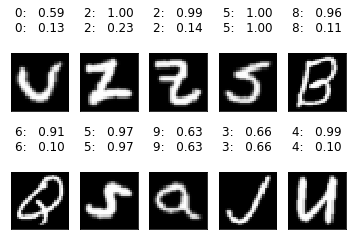

In [39]:
#model.log_pz_lam.data = torch.tensor(-767.132, device=device)
data = enumerate(EMNIST_test_loader).__next__()[1][0]
y = model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base,y], data)

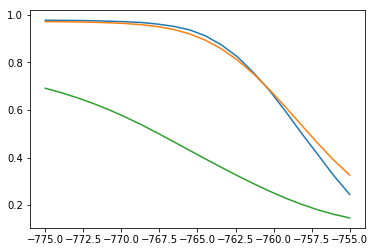

In [525]:
correct = []
conf_MNIST = []
conf_EMNIST = []
lam_vec = torch.linspace(-775.,-755, 20)
for lam in lam_vec:
    model.log_pz_lam.data = torch.tensor(lam, device=device)

    a, b = test(model, device, test_loader)
    correct.append(a)
    conf_MNIST.append(b)

    conf_EMNIST.append(test_adv(model, device, EMNIST_test_loader))

#fig=plt.figure(figsize=(20, 6))
plt.plot(lam_vec.numpy(), np.array(correct)/10000)
plt.plot(lam_vec.numpy(), conf_MNIST)
plt.plot(lam_vec.numpy(), conf_EMNIST)

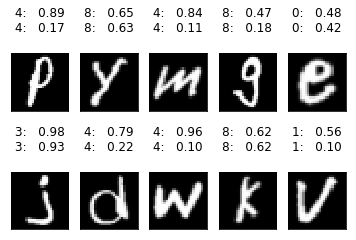

In [42]:
data = enumerate(EMNIST_test_loader).__next__()[1][0]
y = model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y], data)

In [487]:
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output = model(data)
        base_output = base_model(data)
        c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
        c, pred_base = output.max(1, keepdim=True) # get the index of the max log-probability
        if any(pred!= pred_base):
            print('hi')


In [573]:
test(model, device, EMNIST_test_loader_digits)
test(base_model, device, EMNIST_test_loader_digits)



Test set: Average loss: 0.4599, Accuracy: 31865/40000 (80%), Ave. Confidence: 76%


Test set: Average loss: 0.4556, Accuracy: 31961/40000 (80%), Ave. Confidence: 77%



(31961, 0.7668706594467163)

In [19]:
data = enumerate(EMNIST_test_loader).__next__()[1][0]
y = model.gmm(data.view(10,784).to(device))
torch.logsumexp(y, dim=0)

tensor([-764.8209, -751.8403, -759.9078, -775.3289, -765.0276, -782.1302,
        -758.5701, -753.3587, -754.9035, -765.7292], device='cuda:0',
       grad_fn=<LogsumexpBackward>)